# <4. CutMix 또는 Mixup 비교실험 하기 >

## [루브릭]
1.  CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
2.  다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?

## [Data Augmentation]
- 갖고 있는 데이터셋을 여러 가지 방법으로 증강시켜(augment) 실질적인 학습 데이터셋의 규모를 키울 수 있는 방법
- 일반적으로 하드디스크에 저장된 이미지 데이터를 메모리에 로드한 후, 학습시킬 때 변형을 가하는 방법을 사용
- 데이터가 많아진다는 것은 과적합(overfitting)을 줄일 수 있다는 것을 의미
- 또한 우리가 가지고 있는 데이터셋이 실제 상황에서의 입력값과 다를 경우, augmentation을 통해서 실제 입력값과 비슷한 데이터 분포를 만들어 낼 수 있다
- augmentation은 데이터를 늘릴 뿐만 아니라 모델이 실제 테스트 환경에서 잘 동작할 수 있도록 도와주기도 한다

---

## 1. Import

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

---

## 2. 데이터 불러오기
- `stanford_dogs` 데이터셋을 사용
- stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있다. 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteQ0ZPJ4/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteQ0ZPJ4/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


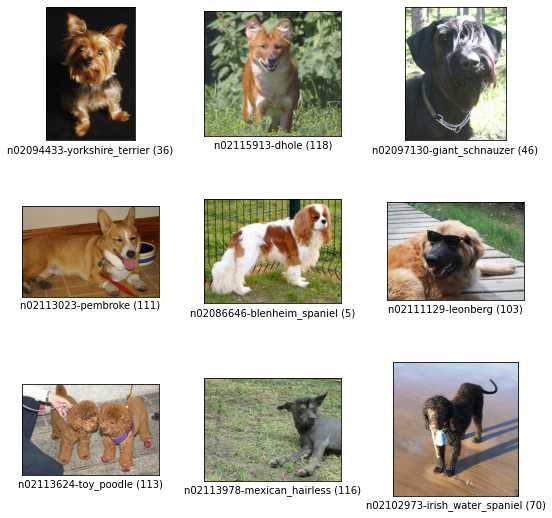

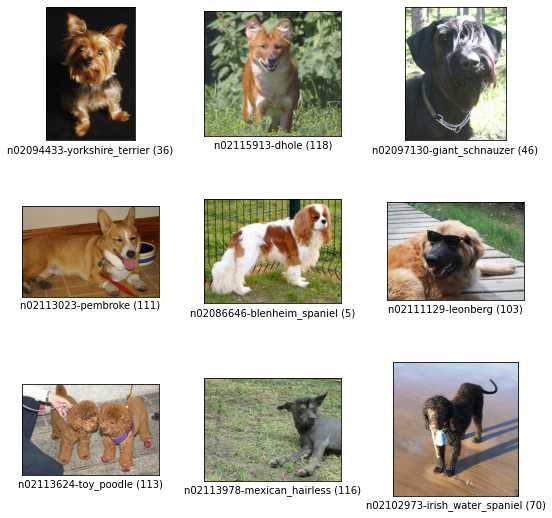

In [ ]:
tfds.show_examples(ds_train, ds_info)

In [ ]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

---

## 3. Cutmix Augmentation

### CutMix
- 네이버 클로바(CLOVA)에서 발표한 CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 에서 제안된 방법
- 이미지 데이터를 자르고 섞는다
- 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함
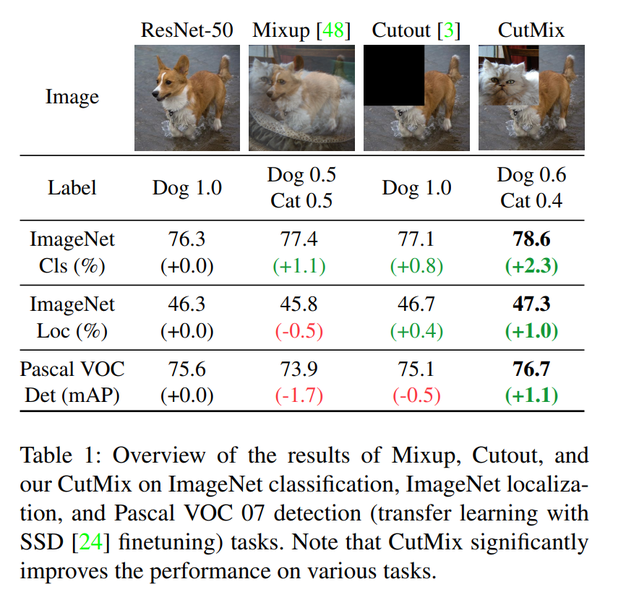

### 바운딩 박스의 위치를 결정하는 함수

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

### 이미지를 합치는 함수

In [ ]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

### 라벨을 섞는 함수
- 이미지를 섞었으니 라벨도 이에 맞게 섞어주어야 한다
- CutMix에서는 면적에 비례해서 라벨을 섞어준다

In [ ]:
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


### CutMix

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b,label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

---

## 4. Mixup Augmentation
- CutMix보다 간단하게 이미지와 라벨을 섞어준다
- 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어 준다

In [ ]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

### Mixup

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

---

## 5. Augmentation 적용
- batch() 함수 뒤에 CutMix가 오는 이유
  - CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 한다

In [ ]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
      ds = ds.map(
          mixup,
          num_parallel_calls = 2
      )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)  #aug, cutmix, mixup 모두 안한 데이터셋
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)      #aug만 적용한 데이터셋
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)   #cutmix만 적용한 데이터셋
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)    #mixup만 적용한 데이터셋
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)           #테스트 데이터셋

---

## 6. 모델 만들기
- `categorical_crossentropy()`를 사용
  - cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
EPOCH = 20
BATCH_SIZE = 16

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

---

## 7. 모델 훈련하기

In [ ]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 172s 202ms/step - loss: 2.1876 - accuracy: 0.4520 - val_loss: 3.0386 - val_accuracy: 0.2587
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 0.6986 - accuracy: 0.8111 - val_loss: 1.0801 - val_accuracy: 0.6872
Epoch 3/20
750/750 [==============================] - 156s 208ms/step - loss: 0.2236 - accuracy: 0.9535 - val_loss: 0.9569 - val_accuracy: 0.7242
Epoch 4/20
750/750 [==============================] - 156s 209ms/step - loss: 0.0632 - accuracy: 0.9937 - val_loss: 0.8930 - val_accuracy: 0.7438
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0275 - accuracy: 0.9985 - val_loss: 0.9150 - val_accuracy: 0.7444
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0136 - accuracy: 0.9998 - val_loss: 0.9200 - val_accuracy: 0.7456
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.9245 -

In [ ]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 184s 227ms/step - loss: 2.2619 - accuracy: 0.4348 - val_loss: 3.1085 - val_accuracy: 0.2780
Epoch 2/20
750/750 [==============================] - 170s 227ms/step - loss: 0.9530 - accuracy: 0.7241 - val_loss: 1.1026 - val_accuracy: 0.6749
Epoch 3/20
750/750 [==============================] - 170s 227ms/step - loss: 0.5234 - accuracy: 0.8533 - val_loss: 1.3971 - val_accuracy: 0.6130
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.2545 - accuracy: 0.9421 - val_loss: 1.0543 - val_accuracy: 0.6962
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 0.1397 - accuracy: 0.9746 - val_loss: 0.9935 - val_accuracy: 0.7177
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 0.1066 - accuracy: 0.9822 - val_loss: 0.9422 - val_accuracy: 0.7330
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0540 - accuracy: 0.9931 - val_loss: 0.9529 -

In [ ]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 166s 204ms/step - loss: 3.8362 - accuracy: 0.2113 - val_loss: 3.6078 - val_accuracy: 0.1855
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 2.9525 - accuracy: 0.4297 - val_loss: 1.4727 - val_accuracy: 0.5969
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.6481 - accuracy: 0.5252 - val_loss: 1.3782 - val_accuracy: 0.6152
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 2.4357 - accuracy: 0.5944 - val_loss: 1.1238 - val_accuracy: 0.6824
Epoch 5/20
750/750 [==============================] - 171s 229ms/step - loss: 2.2974 - accuracy: 0.6388 - val_loss: 1.2000 - val_accuracy: 0.6760
Epoch 6/20
750/750 [==============================] - 156s 209ms/step - loss: 2.1792 - accuracy: 0.6817 - val_loss: 1.4033 - val_accuracy: 0.6356
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.0793 - accuracy: 0.7076 - val_loss: 1.2432 -

In [ ]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 169s 207ms/step - loss: 3.7073 - accuracy: 0.2463 - val_loss: 3.6611 - val_accuracy: 0.1669
Epoch 2/20
750/750 [==============================] - 156s 209ms/step - loss: 2.8416 - accuracy: 0.4831 - val_loss: 1.6033 - val_accuracy: 0.5538
Epoch 3/20
750/750 [==============================] - 157s 210ms/step - loss: 2.5765 - accuracy: 0.5855 - val_loss: 1.4791 - val_accuracy: 0.5852
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 2.3761 - accuracy: 0.6568 - val_loss: 1.3813 - val_accuracy: 0.6206
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 2.2953 - accuracy: 0.6914 - val_loss: 1.2290 - val_accuracy: 0.6672
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 2.1607 - accuracy: 0.7420 - val_loss: 1.2587 - val_accuracy: 0.6560
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.0564 - accuracy: 0.7778 - val_loss: 1.2411 -

---

## 8. 시각화하기

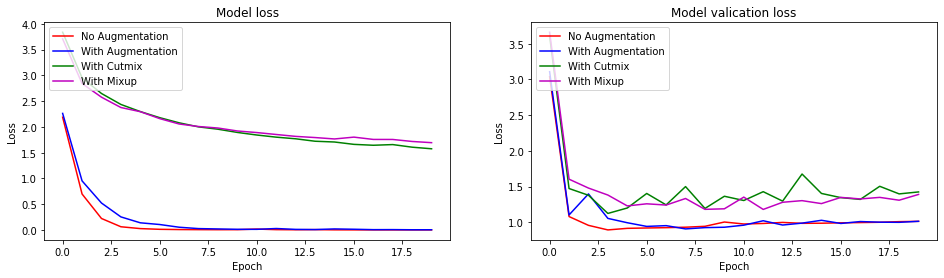

In [ ]:
fig = plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_mixup.history['loss'], 'm')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm')
plt.title('Model valication loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.show()

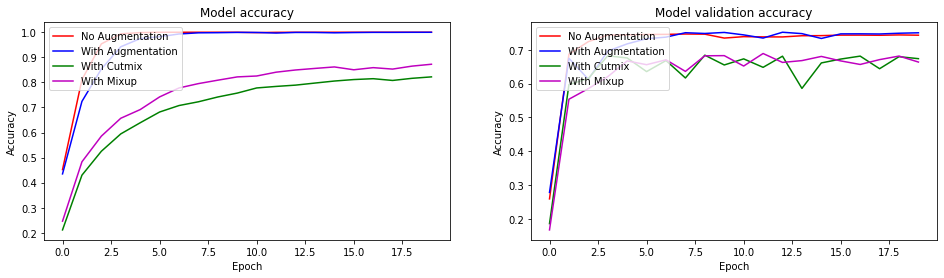

In [ ]:
fig = plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['accuracy'], 'm')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.show()

---

## 9. 정리

### 모델 성능 비교
- 그래프를 보면 augmentation을 적용하지 않은 모델과
random_flip_left_right()과 random_brightness()를 적용시킨 모델 성능이 좋은 것을 볼 수 있다
- 그에 반면 Cutmix와 Mixup은 오히려 성능이 떨어졌다
- loss도 Cutmix와 Mixup이 더 높다

### 회고
- 결과를 보기 전에 Cutmix와 Mixup 기법을 사용하면 오히려 성능이 안좋아질 것이라고 예상을 했었다. cutmix의 경우 object를 판단할 수 있는 위치가 아니라 전혀 다른 부분이 선택된다면 정확도 하락을 가져 올 것이다. 이런 문제는 자르고 섞는 영역을 제한하거나 하면 해결할 수 있지 않을까?
- 다양한 augmentation 기법들을 사용해 볼 수 있어서 좋았다. 
- 중간중간 에러들을 만났었는데 쉽게 해결할 수 있어서 참 다행이었다. 